# Necassary Imports

In [1]:
# Imports
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
#import inflect
#from num2words import num2words
from nltk.corpus import stopwords
from collections import Counter

import sklearn

from gensim.models import Word2Vec

from sklearn.model_selection import ParameterSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV

from nltk.stem import WordNetLemmatizer
import nltk 


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Necassary preprocessing steps

In [2]:
# Import data
df = pd.read_csv('us_equities_news_dataset.csv')

In [3]:
# Filter out Nvidia articles
nvidia_df = df[df['title'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['content'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['ticker'].str.contains('NVIDIA|NVDA', case=False, na=False)]

In [4]:
print(len(nvidia_df))

3464


In [5]:
#Pre processing steps
def preprocess_text_iteration1(text):
    text = text.strip()
    # Replace URLs with an empty string
    re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    words = word_tokenize(text.lower())
    #check if the word is alpha numeric
    alpha_words = [word for word in words if word.isalpha()]
    #remove numbers
    numbers_words = [word for word in alpha_words if not word.isdigit()]
    #stop words removal
    stop_words = set(stopwords.words('english'))
    stop_words_removed = [word for word in numbers_words if not word in stop_words]
    #add lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stop_words_removed]

    return lemmatized_words

# apply preprocessing

# include title in "content"
nvidia_df['content'] = nvidia_df['title'] + ' ' + nvidia_df['content']

nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)

C:\Users\bvits\AppData\Local\Temp\ipykernel_2224\3373882818.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_df['content'] = nvidia_df['title'] + ' ' + nvidia_df['content']
C:\Users\bvits\AppData\Local\Temp\ipykernel_2224\3373882818.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)


In [6]:
#create a document term matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(nvidia_df['content'].apply(lambda x: ' '.join(x)))
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## LDA

[['stock', 'market', 'year', 'nvidia', 'semiconductor', 'investor', 'share', 'nasdaq', 'company', 'price'], ['year', 'company', 'quarter', 'zacks', 'earnings', 'revenue', 'stock', 'estimate', 'growth', 'rank'], ['zacks', 'stock', 'investment', 'research', 'market', 'analyst', 'company', 'portfolio', 'nasdaq', 'security'], ['nasdaq', 'stock', 'nyse', 'market', 'index', 'trade', 'week', 'day', 'share', 'inc'], ['company', 'nvidia', 'technology', 'nasdaq', 'intel', 'chip', 'market', 'driving', 'new', 'ai']]
Topic 0: stock market year nvidia semiconductor investor share nasdaq company price
Topic 1: year company quarter zacks earnings revenue stock estimate growth rank
Topic 2: zacks stock investment research market analyst company portfolio nasdaq security
Topic 3: nasdaq stock nyse market index trade week day share inc
Topic 4: company nvidia technology nasdaq intel chip market driving new ai
[[3.40030615e-01 6.09104025e-04 6.10401447e-04 6.58142694e-01
  6.07185029e-04]
 [4.60911343e-01

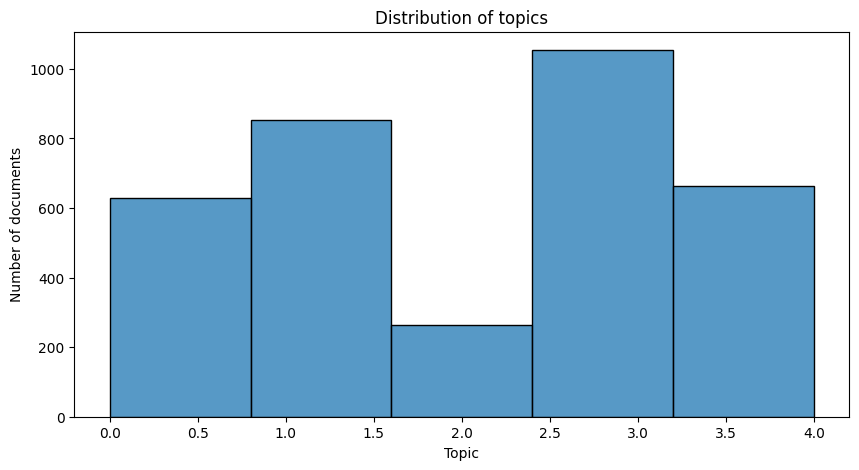

In [7]:
# train LDAModel
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, random_state=0) #once I can run zeroth it, change n_components to something else
lda.fit(X)

# get topics
def get_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    topics = []
    for topic in model.components_:
        topic_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(topic_words)
    return topics

topics = get_topics(lda, vectorizer, 10)
print(topics)
for i, topic in enumerate(topics):
    print('Topic {}: {}'.format(i, ' '.join(topic)))


# get topic distribution for each document
topic_dist = lda.transform(X)
print(topic_dist)

# plot the distribution of topics
plt.figure(figsize=(10, 5))
sns.histplot(topic_dist.argmax(axis=1), bins=5)
plt.xlabel('Topic')
plt.ylabel('Number of documents')
plt.title('Distribution of topics')
plt.show()



In [8]:
# create a cluster plot for the topics

#if we have more time we look this because it is a cool plot (we don't fully understand it because copilot made it)

# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=0)
# tsne_embedding = tsne.fit_transform(topic_dist)
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=tsne_embedding[:, 0], y=tsne_embedding[:, 1], hue=topic_dist.argmax(axis=1), palette='tab10')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# plt.title('t-SNE plot of topics')
# plt.show()

## FLSA-W

In [9]:
# FuzzyTM FLSA-W
from FuzzyTM import FLSA_W

# Coherence and Diversity



In [10]:


# create a FLSA-W model (based on the previous iteration, we can conclude that 5 topics is best)
# We continue with 5 topics since we notice the coherence is highest, and the diversity is also good (but not the highest)
flsaW = FLSA_W(
input_file = nvidia_df['content'].to_list(),
num_topics=5,
num_words=10,
)

In [11]:
flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL
print(flsaW.show_topics())


[(0, '0.0006*"gmt" + 0.0004*"outnumbered" + 0.0004*"settle" + 0.0003*"slumped" + 0.0003*"performer" + 0.0003*"troy" + 0.0003*"dax" + 0.0003*"aug" + 0.0003*"strategiesit" + 0.0003*"unveils"'), (1, '0.0128*"book" + 0.0105*"evolution" + 0.0092*"richard" + 0.0081*"certainty" + 0.008*"mind" + 0.0074*"professor" + 0.0073*"science" + 0.0066*"modern" + 0.0064*"knowledge" + 0.0052*"synthesis"'), (2, '0.0002*"premarket" + 0.0002*"company" + 0.0002*"market" + 0.0002*"also" + 0.0002*"nasdaq" + 0.0002*"stock" + 0.0002*"new" + 0.0002*"reiterates" + 0.0002*"time" + 0.0002*"one"'), (3, '0.001*"traded" + 0.0008*"reuters" + 0.0007*"worst" + 0.0007*"composite" + 0.0007*"previously" + 0.0007*"lowest" + 0.0007*"ltd" + 0.0007*"sporting" + 0.0007*"chipmaker" + 0.0007*"donald"'), (4, '0.0021*"nvidia" + 0.002*"nvda" + 0.0019*"com" + 0.0017*"nasdaq" + 0.0017*"advanced" + 0.0017*"rank" + 0.0017*"intc" + 0.0016*"released" + 0.0016*"among" + 0.0016*"positive"')]


## Compute Diversity, Coherence, Interpretability for FLSA-W and LDA

In [ ]:
for topic in flsaW.show_topics(representation='words'):
    print(topic)


print(flsaW.get_coherence_score()) # ask if this has to be high
print(flsaW.get_diversity_score()) # ask if this has to be high
print(flsaW.get_interpretability_score()) # ask if this has to be high




['gmt', 'outnumbered', 'settle', 'slumped', 'performer', 'troy', 'dax', 'aug', 'strategiesit', 'unveils']
['book', 'evolution', 'richard', 'certainty', 'mind', 'professor', 'science', 'modern', 'knowledge', 'synthesis']
['premarket', 'company', 'market', 'also', 'nasdaq', 'stock', 'new', 'reiterates', 'time', 'one']
['traded', 'reuters', 'worst', 'composite', 'previously', 'lowest', 'ltd', 'sporting', 'chipmaker', 'donald']
['nvidia', 'nvda', 'com', 'nasdaq', 'advanced', 'rank', 'intc', 'released', 'among', 'positive']


In [ ]:
#coherence for lda (we make sure tha the content is the same as the content used to train FLSA-W and LDA)
coherence_lda = flsaW.get_coherence_score(
nvidia_df['content'].to_list(),
topics)

print(coherence_lda)

0.48413451396582863


In [ ]:
#diversity for lda (we make sure tha the content is the same as the content used to train FLSA-W and LDA)
diversity_lda = flsaW.get_diversity_score(topics)
print(diversity_lda)

0.68


In [ ]:
#lda interpretability
interpretability_lda = diversity_lda * coherence_lda
print(interpretability_lda)

0.3292114694967635


## Elbow plots (FLSA-W and LDA)

1
2
3
4
5
6
7
8
9
10


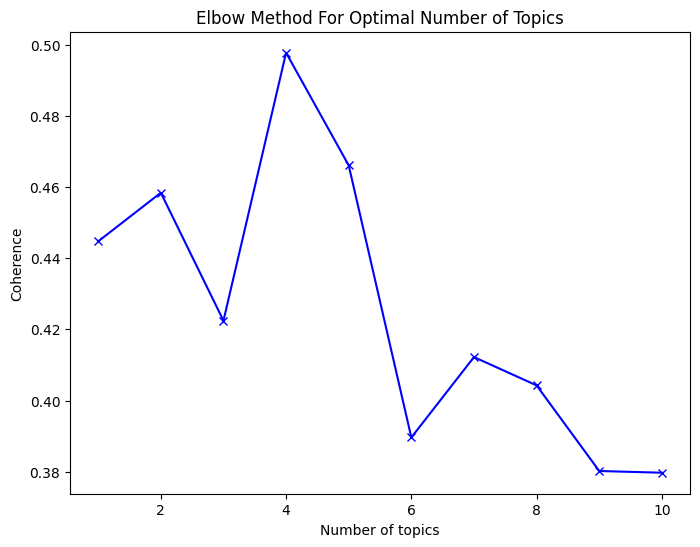

In [ ]:
#elbow plot for FLSA-W
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    #train model
    print(n_topics)
    flsaW_elbow = FLSA_W(
    input_file = nvidia_df['content'].to_list(),
    num_topics=n_topics,
    num_words=10,
    )
    flsaW_elbow.get_vocabulary_size()
    pwgt, ptgd = flsaW_elbow.get_matrices() # THIS TRAINS THE MODEL
    #get coherence
    coherence = flsaW_elbow.get_coherence_score()
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics')
plt.show()


1
2
3
4
5
6
7
8
9
10


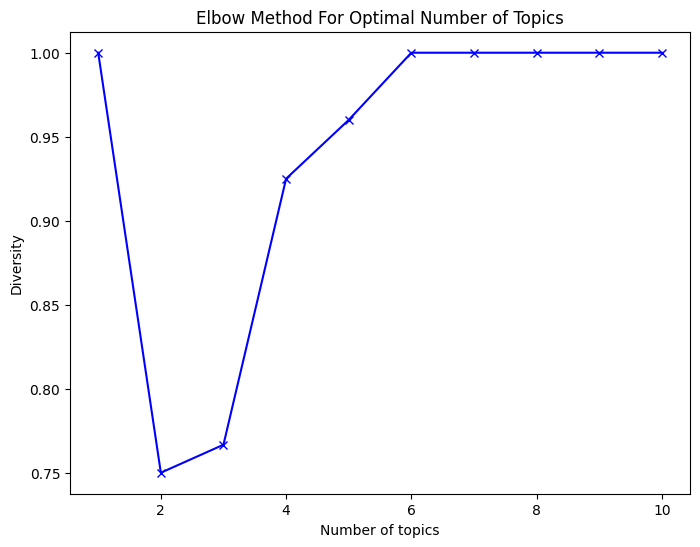

In [ ]:
#elbow plot for diversity

#elbow plot for FLSA-W
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    flsaW_elbow = FLSA_W(
    input_file = nvidia_df['content'].to_list(),
    num_topics=n_topics,
    num_words=10,
    )
    flsaW_elbow.get_vocabulary_size()
    pwgt, ptgd = flsaW_elbow.get_matrices() # THIS TRAINS THE MODEL
    #get diversity
    diversity = flsaW_elbow.get_diversity_score()
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics')
plt.show()


1
2
3
4
5
6
7
8
9
10


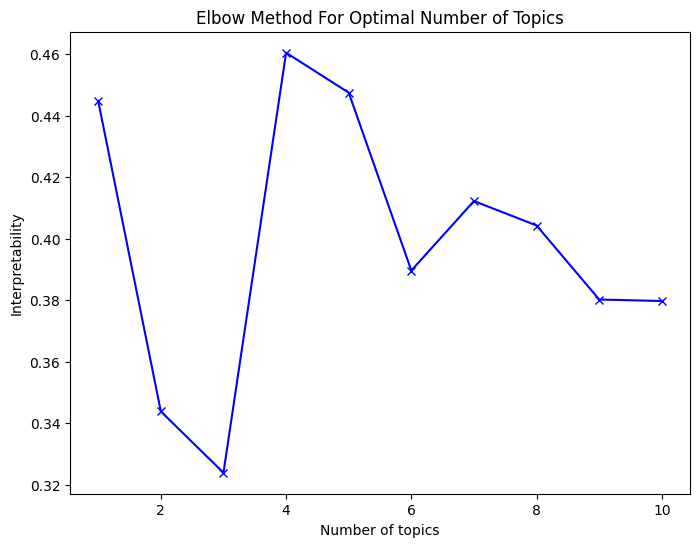

In [ ]:
#elbow plot for interpretability
range_n_topics = range(1, 11)
#elbow plot for FLSA-W
interpretabilities = []
for i in range_n_topics:
    print(i)
    interpretability =  coherences[i-1]*diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics')
plt.show()

## LDA

1
2
3
4
5
6
7
8
9
10


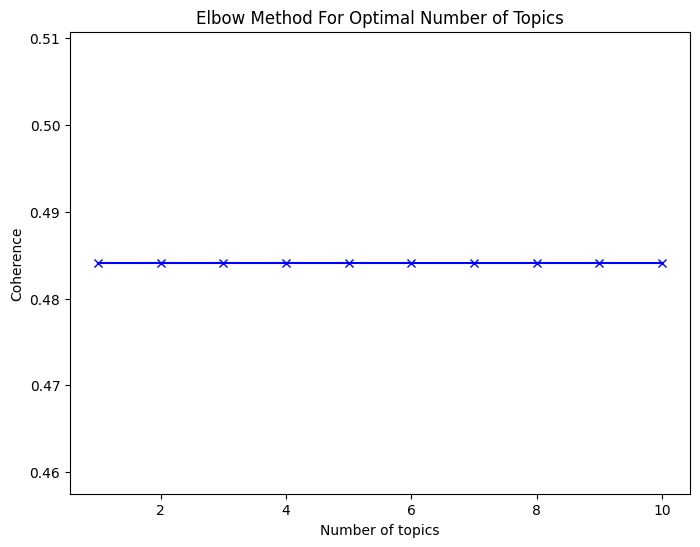

In [ ]:
#elbow plot for coherence

#elbow plot for LDA
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    lda = LatentDirichletAllocation(n_components=5, random_state=0)
    lda.fit(X)
    #get coherence
    coherence = flsaW.get_coherence_score(
    nvidia_df['content'].to_list(),
    topics)
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics')
plt.show()


1
2
3
4
5
6
7
8
9
10


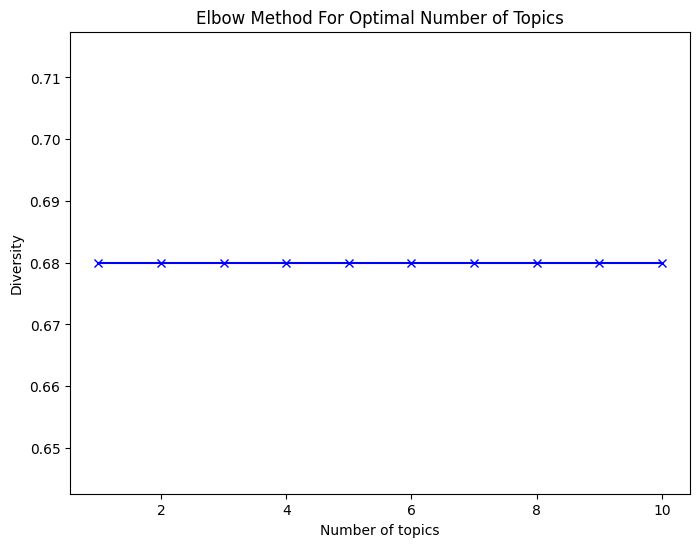

In [ ]:
#elbow plot for diversity

#elbow plot for LDA
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    lda = LatentDirichletAllocation(n_components=5, random_state=0)
    lda.fit(X)
    #get diversity
    diversity = flsaW.get_diversity_score(
    
    topics)
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics')
plt.show()

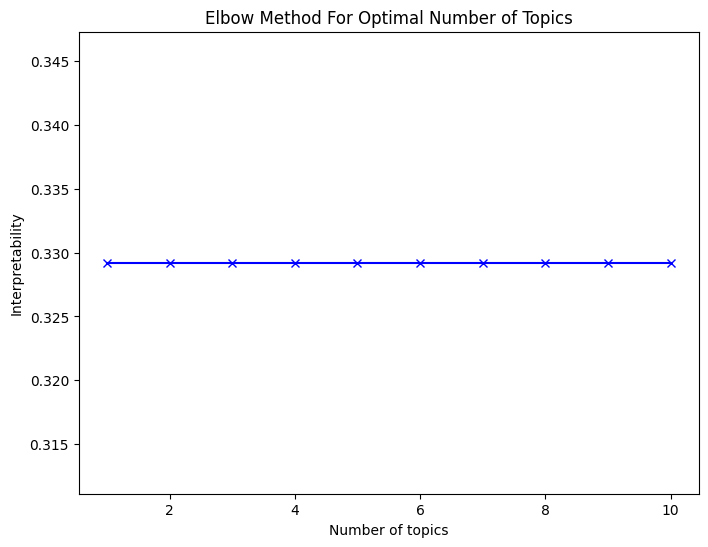

In [ ]:
#elbow plot for interpretability

#elbow plot for LDA
interpretabilities = []
for i in range_n_topics:
    interpretability = coherences[i-1] * diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics')
plt.show()

They remain stable. It would be interesting to write a discussion. (there is little variation why?)

## Bert Topic

In [ ]:
from bertopic import BERTopic
from umap import UMAP
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=0)
docs = [' '.join(doc) for doc in nvidia_df['content']]
# Create the model (uses DistilBERT by default)
bert_topic = BERTopic(umap_model=umap_model)
# Train the model and transform your data into topics
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)
topic_matrix = bert_topic.get_topic_info()
bert_topic.get_topics()



{-1: [('zacks', 0.007850187293418206),
  ('nasdaq', 0.007838253852146166),
  ('stocks', 0.007799777486119565),
  ('year', 0.007776103036603153),
  ('market', 0.007281461532975745),
  ('nvidia', 0.00723744635893396),
  ('company', 0.0071243253262965305),
  ('earnings', 0.007043631566139969),
  ('growth', 0.006631207783470012),
  ('stock', 0.006510777903859133)],
 0: [('million', 0.025903351892932035),
  ('quarter', 0.02238561683195014),
  ('revenues', 0.020672449292052017),
  ('year', 0.01914394610206537),
  ('company', 0.017779557964429493),
  ('zacks', 0.017632405641972944),
  ('cents', 0.0159496766094474),
  ('consensus', 0.014372106109621693),
  ('estimate', 0.014323940517080705),
  ('gaap', 0.0135110855884443)],
 1: [('amd', 0.06036767666480116),
  ('graphics', 0.022490810176694145),
  ('radeon', 0.02160748820945311),
  ('gpu', 0.02021407624007519),
  ('ryzen', 0.018121657172387295),
  ('processors', 0.015521842959839542),
  ('epyc', 0.014893376515931424),
  ('micro', 0.01390178647

In [ ]:
print(topic_matrix)

    Topic  Count                                Name  \
0      -1   1141         -1_zacks_nasdaq_stocks_year   
1       0    166     0_million_quarter_revenues_year   
2       1    118           1_amd_graphics_radeon_gpu   
3       2     79  2_driving_self_autonomous_vehicles   
4       3     67   3_semiconductor_earnings_etf_beta   
..    ...    ...                                 ...   
73     72     11          72_traded_gmt_seven_lowest   
74     73     11     73_google_alphabet_android_java   
75     74     10      74_investment_zacks_year_sales   
76     75     10          75_target_market_price_day   
77     76     10   76_percent_fed_bernanke_inflation   

                                       Representation  \
0   [zacks, nasdaq, stocks, year, market, nvidia, ...   
1   [million, quarter, revenues, year, company, za...   
2   [amd, graphics, radeon, gpu, ryzen, processors...   
3   [driving, self, autonomous, vehicles, car, car...   
4   [semiconductor, earnings, etf, beta, i

In [ ]:
bert_topic.visualize_heatmap()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_million_quarter_revenues, 1_amd_graphics_radeon,
                    2_driving_self_autonomous, 3_semiconductor_earnings_etf,
                    4_target_nvidia_rating, 5_tracey_podcast_value,
                    6_apple_iphone_year, 7_performers_close_inc,
                    8_resistance_roku_towards, 9_nyse_dow_closed, 10_tech_fang_etf,
                    11_bitcoin_blockchain_crypt..., 12_driving_self_autonomous,
                    13_earnings_estimates_growth, 14_walmart_might_wmt,
                    15_semiconductor_china_indu..., 16_gaming_quarter_year,
                    17_facebook_users_user, 18_might_week_market,
                    19_analyst_zacks_reports, 20_million_revenues_quarter,
                    21_stock_nasdaq_investing, 22_trade_china_trump,
                    23_futures_points_et, 24_traded_gmt_seven,
                    25_cadence_design_ansys, 26_intel_swan_chips,
                    27_inc_nyse_nasdaq, 28_traded_gmt_seven, 29_day_trading_call,
                    30_oil_crude_prices, 31_earnings_year_shares,
                    32_china_trade_chinese, 33_revenue_eps_com,
                    34_mellanox_ethernet_marvell, 35_intel_ai_israel,
                    36_us_targets_scenario, 37_resistance_around_level,
                    38_micron_mu_dram, 39_ai_robotics_ml, 40_nvidia_gaming_nvda,
                    41_nvidia_revenue_percent, 42_traded_gmt_seven,
                    43_rtx_gaming_tracing, 44_nvidia_nvda_projected,
                    45_quarter_earnings_estimates, 46_qualcomm_commission_pate...,
                    47_traded_gmt_seven, 48_ai_cloud_instances,
                    49_huawei_china_chinese, 50_trader_today_editor,
                    51_percent_dollar_yield, 52_traded_gmt_seven,
                    53_traded_gmt_seven, 54_percent_reuters_randewich,
                    55_hp_intel_dell, 56_yesterday_nyse_week,
                    57_rallied_australian_climbed, 58_oil_forecasts_sales,
                    59_western_digital_storage, 60_microsoft_azure_google,
                    61_qualcomm_chips_broadcom, 62_coronavirus_virus_china,
                    63_storage_pure_flashblade, 64_esports_game_video,
                    65_baidu_apollo_driving, 66_miners_cryptocurrency_cr...,
                    67_nand_microchip_quarter, 68_games_stadia_game,
                    69_options_implied_volatility, 70_futures_points_et,
                    71_losers_ndls_read, 72_traded_gmt_seven,
                    73_google_alphabet_android, 74_investment_zacks_year,
                    75_target_market_price, 76_percent_fed_bernanke],
              'xaxis': 'x',
              'y': [0_million_quarter_revenues, 1_amd_graphics_radeon,
                    2_driving_self_autonomous, 3_semiconductor_earnings_etf,
                    4_target_nvidia_rating, 5_tracey_podcast_value,
                    6_apple_iphone_year, 7_performers_close_inc,
                    8_resistance_roku_towards, 9_nyse_dow_closed, 10_tech_fang_etf,
                    11_bitcoin_blockchain_crypt..., 12_driving_self_autonomous,
                    13_earnings_estimates_growth, 14_walmart_might_wmt,
                    15_semiconductor_china_indu..., 16_gaming_quarter_year,
                    17_facebook_users_user, 18_might_week_market,
                    19_analyst_zacks_reports, 20_million_revenues_quarter,
                    21_stock_nasdaq_investing, 22_trade_china_trump,
                    23_futures_points_et, 24_traded_gmt_seven,
                    25_cadence_design_ansys, 26_intel_swan_chips,
                    27_inc_nyse_nasdaq, 28_traded_gmt_seven, 29_day_trading_call,
                    30_oil_crude_prices, 31_earnings_year_shares,
                    32_china_trade_chinese, 33_r

In [ ]:
topic_matrix.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1141,-1_zacks_nasdaq_stocks_year,"[zacks, nasdaq, stocks, year, market, nvidia, ...",[immediate release chicago il may today zacks ...
1,0,166,0_million_quarter_revenues_year,"[million, quarter, revenues, year, company, za...",[keeping earnings streak alive palo alto netwo...
2,1,118,1_amd_graphics_radeon_gpu,"[amd, graphics, radeon, gpu, ryzen, processors...",[month since last earnings report advanced mic...
3,2,79,2_driving_self_autonomous_vehicles,"[driving, self, autonomous, vehicles, car, car...",[intel corporation nasdaq intc recent deal win...
4,3,67,3_semiconductor_earnings_etf_beta,"[semiconductor, earnings, etf, beta, industry,...",[semiconductor corner broad technology market ...
5,4,66,4_target_nvidia_rating_analyst,"[target, nvidia, rating, analyst, price, previ...",[nvidia nasdaq nvda reported results yesterday...
6,5,65,5_tracey_podcast_value_investment,"[tracey, podcast, value, investment, stocks, z...",[immediate releasechicago il dec zacks value i...
7,6,62,6_apple_iphone_year_billion,"[apple, iphone, year, billion, services, quart...",[earnings season heats wall street watching ap...
8,7,61,7_performers_close_inc_rose,"[performers, close, inc, rose, settle, points,...",[investing com u stocks lower close thursday l...
9,8,57,8_resistance_roku_towards_stock,"[resistance, roku, towards, stock, around, bre...",[stock market predictions week july p spy p pi...


In [ ]:
# print the name of the topic matrix and the representative docs using for loop
for i in range(0, 11):
    print(topic_matrix['Name'][i])
    print(topic_matrix['Representative_Docs'][i])
    print('')

-1_zacks_nasdaq_stocks_year
['immediate release chicago il may today zacks investment ideas feature highlights features nvidia nasdaq lam research nasdaq analog devices nasdaq still chasing nvidia stayed long shares nvidia nasdaq earnings big congratulations order unfortunately followers listened crowd wall street investment bank analysts neutral bearish stock valuation concerns recommended taking profits near another solid earnings report may launched nvda toward quickly became time highs reviewing company report show outlook next day immediately knew made mistake even though none banks price targets near ready admit could besides suck pay hope stock would slow bit give us chance get back sure could pay eps multiple maker hot selling ai chips called gpus used everything gaming consoles ibm nyse ibm watson driverless wheelers europe latest cloud computing customer service security applications reasoned nvidia brand ai hardware going stay dominant demand several quarters years certainly

In [ ]:
#create a list of the first 10 representative docs
rep_docs = topic_matrix['Representation'][1:6].to_list()
print(rep_docs)




[['million', 'quarter', 'revenues', 'year', 'company', 'zacks', 'cents', 'consensus', 'estimate', 'gaap'], ['amd', 'graphics', 'radeon', 'gpu', 'ryzen', 'processors', 'epyc', 'micro', 'year', 'intel'], ['driving', 'self', 'autonomous', 'vehicles', 'car', 'cars', 'vehicle', 'tesla', 'mobileye', 'said'], ['semiconductor', 'earnings', 'etf', 'beta', 'industry', 'score', 'zacks', 'rank', 'semiconductors', 'stock'], ['target', 'nvidia', 'rating', 'analyst', 'price', 'previously', 'raises', 'reiterates', 'read', 'premarket']]


In [ ]:
#bert coherence --> just say we tried, in the end it doesn't matter I tried hard and got so far 
print(
flsaW.get_coherence_score(
nvidia_df['content'].to_list(),
rep_docs)
)


0.6868210750171275


In [ ]:
#bert diversity
print(flsaW.get_diversity_score(rep_docs))

0.96


topic